# RAG을 이브이처럼 진화시켜보자!

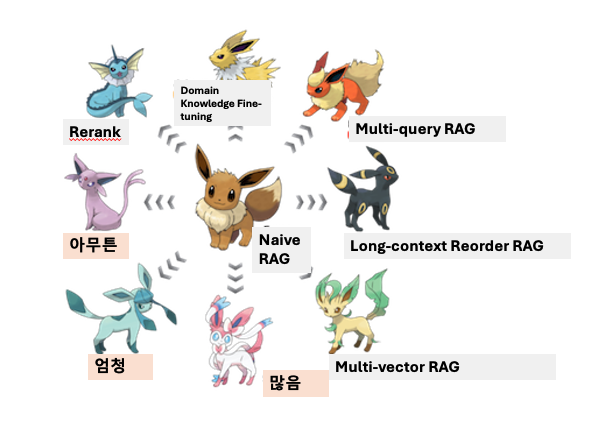

In [ ]:
!pip install langchain_openai
!pip install langchain-community
!pip install pypdf
!pip install faiss-cpu
!pip install -qU "langchain-community>=0.2.11" tavily-python
!pip install langsmith

In [ ]:
import os
from getpass import getpass

os.environ["OPENAI_API_KEY"] = getpass("OpenAI API key 입력: ")

OpenAI API key 입력: ··········


# 1. multi-query retriever

기존 RAG의 단점을 알아보겠습니다.

RAG은 사용자의 질문과 가장 유사한 청크를 바탕으로 근거자료를 찾는 것이 핵심입니다. 하지만, 올바른 근거를 찾기위해서 사용자의 질문을 활용하므로, **질문 문장이 벡터 DB내 청크들과 유사하지 않은 경우 역설적으로 근거를 찾기 어렵습니다.**



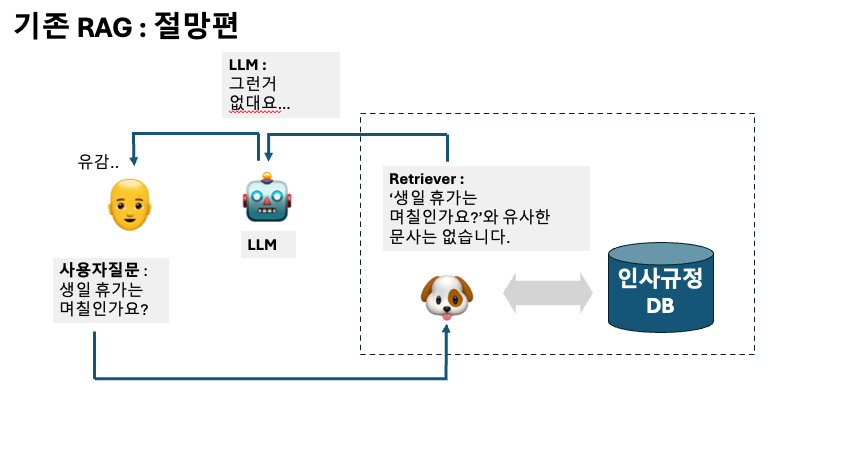

> MultiQueryRetriever는 사용자의 쿼리를 재해석해 검색합니다.


이를 해결하기 위해 **multi query retriever는 '사용자 질문을 여러버전으로 만들어 벡터 DB내 검색이 원활하게'** 만듭니다.

즉, 사용자 질문의 목적을 다각도로 해석하여 여러 버전의 질문 문장을 만들어내는 것이 핵심입니다.

그리고 이를 바탕으로 유사 청크를 검색하면 사용자 질문 원본으로 찾을 수 없던 근거를 찾을 수 있게됩니다.

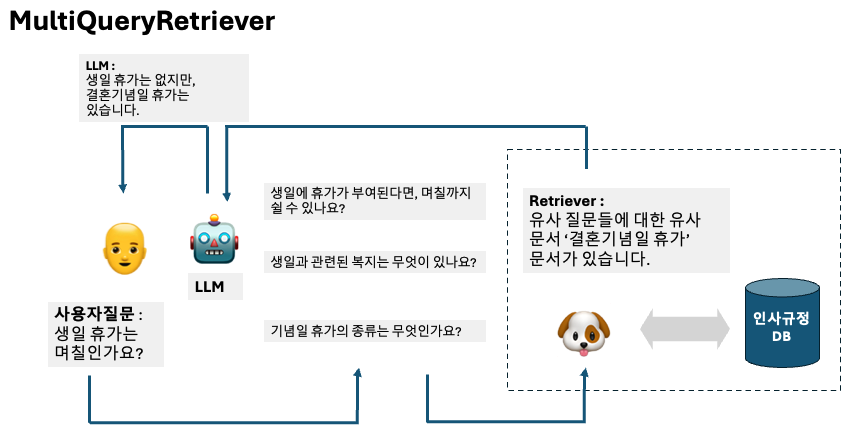

In [ ]:

 #RAG (Retrieval-Augmented Generation) 모델을 사용한 챗봇을 구축하고 실행하는 예제
 #RAG 모델은 외부 문서나 데이터를 검색하여, 그 검색된 정보를 생성 모델 (예: GPT)과 결합하여 더 정확하고 풍부한 답변을 제공하는 방식

from langchain_community.vectorstores import FAISS
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_openai import OpenAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain.document_loaders import PyPDFLoader


####################
####### RAG 챗봇 구축
###################

# 1. LLM 모델 불러오기
llm = ChatOpenAI(model="gpt-4o-mini")

# 2. 문서 불러오기
loader = PyPDFLoader("/content/[2024 한권으로 OK 주식과 세금].pdf") # PDF 파일을 로드하여 텍스트로 변환하는 도구
docs = loader.load() # 로드된 PDF 문서에서 텍스트 데이터를 포함하는 문서 객체 리스트

# 3. 문서 chunking 하기
# RecursiveCharacterTextSplitter는 문서를 일정한 크기로 나누는 역할을 한다.
# 이때, chunk_size는 한 덩어리로 나눌 텍스트의 크기(1000자), chunk_overlap은 각 덩어리 사이의 중복되는 부분(200자)다.
# splits는 나누어진 문서 덩어리들(chunks)을 담은 리스트
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
splits = text_splitter.split_documents(docs)

# 4. 자른 chunk들을 embedding 하기
# OpenAIEmbeddings는 텍스트를 임베딩 벡터로 변환하는 클래스.
# model="text-embedding-ada-002"는 OpenAI의 Ada 모델을 사용하여 텍스트를 수치 벡터로 변환한.
이 벡터들은 이후 검색과 유사도 비교에 사용됩니다.
embeddings = OpenAIEmbeddings(model="text-embedding-ada-002")

# 5. vector store 구축하기
# FAISS는 Facebook AI에서 개발한 벡터 검색 시스템.
# from_documents() 메서드는 splits에서 생성한 문서 덩어리들을 임베딩 벡터로 변환하여 벡터 스토어를 구축한다.
# vectorstore는 문서 벡터를 저장하고, 이를 통해 검색이 가능하게 된다.
vectorstore = FAISS.from_documents(documents=splits, embedding=embeddings)

# 6. retriever 구축하기
# vectorstore.as_retriever()는 검색 기능을 제공하는 retriever를 생성.
# 이 retriever는 사용자가 입력한 질문에 대해 관련된 문서 조각들을 검색한다.
retriever = vectorstore.as_retriever()

# 7. 프롬프트 템플릿 구축하기
# ChatPromptTemplate.from_template()는 텍스트 템플릿을 기반으로 프롬프트 템플릿을 만든다.
# {context}는 검색된 관련 문서를 넣는 자리표시자이며, {question}은 사용자가 질문한 내용을 넣는 자리표시자이다.
# 이 프롬프트 템플릿은 검색된 문서와 질문을 결합하여 모델이 그에 맞는 응답을 생성하도록 합니다.
prompt = prompt = ChatPromptTemplate.from_template("""
오로지 아래의 context만을 기반으로 질문에 대답하세요:
{context}
질문:
{question}
""")


# 8. 1~7. 요소들을 chain으로 조합하여 RAG 구축 완료
# RAG는 검색된 정보(context)와 질문(question)을 결합하여 모델을 통해 응답을 생성하는 과정
# format_docs(docs)는 retriever에서 검색한 문서들을 형식에 맞게 텍스트로 변환하는 함수
# rag_chain은 여러 개의 요소를 연결한 체인
# retriever | format_docs: 검색된 문서(retriever)를 텍스트로 변환
# RunnablePassthrough(): 사용자의 질문을 그대로 전달하는 역할을 한다.
# | prompt: 프롬프트 템플릿에 입력 데이터를 전달
# | llm: GPT 모델을 사용하여 대답을 생성
# | StrOutputParser(): 응답을 문자열 형태로 변환합
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)


####################
####### 구축한 RAG 챗봇 실행
###################


# rag_chain.invoke()는 사용자 질문을 입력으로 받아 RAG 체인을 실행
# 주어진 질문을 통해 검색된 문서와 결합하여 GPT 모델이 적절한 답변을 생성
rag_chain.invoke("상장주식 대주주 기준이 50억 원 이상으로 완화되었는데 언제부터 적용되는 건가요?")

'상장주식 대주주 기준이 50억 원 이상으로 완화된 것은 2023년 말부터 적용되며, 2024년 1월 1일 이후 양도하는 분부터 적용됩니다. 따라서 2024년 상반기 양도분에 대해서는 2024년 8월 예정신고 시부터 적용됩니다.'

In [ ]:
from langchain.retrievers.multi_query import MultiQueryRetriever
from langchain_openai import ChatOpenAI

# 질문 문장을 question으로 저장
question = "해외 주식을 팔때 뭘 신경써야하나요?"
# 여러 버전의 질문을 변환하는 역할을 맡은 LLM 선언
llm = ChatOpenAI(model_name="gpt-4o-mini")

#MultiQueyrRetriever에 벡터기반 Retreiver와 LLM 선언
retreiver_from_llm = MultiQueryRetriever.from_llm(
    retriever = vectorstore.as_retriever(), llm=llm
)

# 여러 버전 문장 생성 결과를 확인하기 위한 로깅 과정
import logging
logging.basicConfig()
logging.getLogger("langchain.retrievers.multi_query").setLevel(logging.INFO)

# 여러 버전 질문 생성 결과와 유사 청크 검색 갯수 출력
unique_docs = retreiver_from_llm.invoke(input=question)
print(f"Found {len(unique_docs)} unique documents")

INFO:langchain.retrievers.multi_query:Generated queries: ['해외 주식을 매도할 때 고려해야 할 사항은 무엇인가요?  ', '해외 주식 판매 시 주의해야 할 점은 무엇인지 알려주세요.  ', '해외 주식을 판매할 때 반드시 확인해야 할 요소는 어떤 것들이 있나요?']


Found 5 unique documents


이외에도 문서를 여러 벡터로 재해석하는 MultiVectorRetriever, 긴 컨텍스트가 프롬프트 안에 들어갈때를 대비하는 Long-context reorder등으로 기존 RAG의 단점을 보완하고자 하는시도들이 많이 있습니다.

아직은 이른 것 같아 소개하지 않지만, 추후 수업에서 다룰 기회가 있으면 좋겠네요 ^__^


## 💡 실습 : 위의 MultiQueryRetriever를 RAG에 붙여보자!!

위에서 주어진 기존 RAG 코드에 MultiQueryRetriever를 붙여봅시다.

간단합니다. 기존의 리트리버를 이 MultiQueryRetriever로 대체하면 됩니다. 😄

In [ ]:
'''

기존 RAG 코드에 MultiQueryRetriever를

'''

from langchain_community.vectorstores import FAISS
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_openai import OpenAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain.document_loaders import PyPDFLoader

from langchain_community.retrievers import MultiQueryRetriever


####################
####### RAG 챗봇 구축
###################

# 1. LLM 모델 불러오기
llm = ChatOpenAI(model="gpt-4o-mini")

# 2. 문서 불러오기
loader = PyPDFLoader("/content/[2024 한권으로 OK 주식과 세금].pdf")
docs = loader.load()

# 3. 문서 chunking 하기
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
splits = text_splitter.split_documents(docs)

# 4. 자른 chunk들을 embedding 하기
embeddings = OpenAIEmbeddings(model="text-embedding-ada-002")

# 5. vector store 구축하기
vectorstore = FAISS.from_documents(documents=splits, embedding=embeddings)

# # 6. MultiQueryRetriever 구축하기 (기존 retriever를 MultiQueryRetriever로 변경)
multi_query_retriever = MultiQueryRetriever(base_retriever=vectorstore.as_retriever())

# 7. 프롬프트 템플릿 구축하기
prompt = prompt = ChatPromptTemplate.from_template("""
오로지 아래의 context만을 기반으로 질문에 대답하세요:
{context}
질문:
{question}
""")


# 8. 1~7. 요소들을 chain으로 조합하여 RAG 구축 완료
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

rag_chain = (
    {"context": multi_query_retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

# {"context": retriever | format_docs, "question": RunnablePassthrough()}



####################
####### 구축한 RAG 챗봇 실행
###################

rag_chain.invoke("상장주식 대주주 기준이 50억 원 이상으로 완화되었는데 언제부터 적용되는 건가요?")

'상장주식 대주주 기준이 50억 원 이상으로 완화된 것은 2024년 1월 1일부터 적용됩니다. 이 기준은 2023년 말 기준으로 판단되며, 2024년 상반기 양도분에 대해 2024년 8월 예정신고 시부터 적용됩니다.'

# 2. agent + RAG

앞서 배운 agent를 RAG에 붙여보겠습니다!

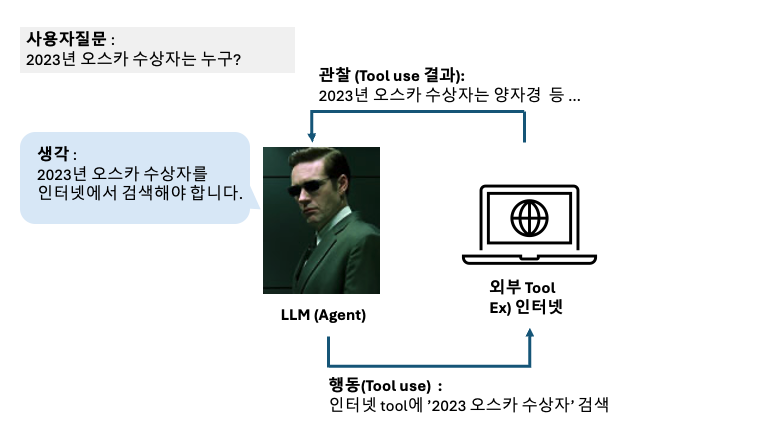

이제는 주어진 문서가 필요한 질문일때는, 주어진 문서를 기반으로 답변을 하고

인터넷 검색이 필요한 질문일때는, 인터넷 검색을 기반으로 답변을 하는 agent 입니다!

In [ ]:
import os
import getpass

os.environ["TAVILY_API_KEY"] = getpass.getpass("Tavily API key:\n")

Tavily API key:
··········


In [ ]:
from langchain_community.vectorstores import FAISS
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_openai import OpenAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain.document_loaders import PyPDFLoader

from langchain_community.tools import TavilySearchResults
from langchain.tools.retriever import create_retriever_tool
from langchain.agents import create_openai_tools_agent
from langchain.agents import AgentExecutor

from langchain import hub


####################
####### RAG 챗봇 구축
###################

# 1. LLM 모델 불러오기
llm = ChatOpenAI(model="gpt-4o-mini")

# 2. 문서 불러오기
loader = PyPDFLoader("/content/[2024 한권으로 OK 주식과 세금].pdf")
docs = loader.load()

# 3. 문서 chunking 하기
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
splits = text_splitter.split_documents(docs)

# 4. 자른 chunk들을 embedding 하기
embeddings = OpenAIEmbeddings(model="text-embedding-ada-002")

# 5. vector store 구축하기
# **FAISS(Vector Store)**는 대량의 텍스트 데이터를 벡터로 변환하여 빠르게 검색할 수 있게 도와주는 라이브러리
# splits로 분할된 문서 청크를 FAISS 벡터 저장소에 추가하여 빠른 검색 기능을 제공
vectorstore = FAISS.from_documents(documents=splits, embedding=embeddings)

# 6. retriever 구축하기
# Retriever: 저장된 벡터에서 관련 정보를 검색할 수 있는 기능을 제공. FAISS에서 구축된 vectorstore를 기반으로 검색을 할 수 있도록 설정
retriever = vectorstore.as_retriever()

############ 7. retriever tool 구축하기
retriever_tool = create_retriever_tool(
    retriever, # 검색할 대상인 리트리버
    "stock", # 검색 tool의 이름
    "세금, 주식, 세법과 관련된 질문이 입력되면 이 도구를 사용합니다."
)

# Retriever Tool: 검색 도구를 생성
# create_retriever_tool 함수는 주어진 retriever와 관련된 질문을 처리할 수 있는 도구를 만들어준다.
# 여기서 "stock"은 검색 도구의 이름이고, 주식, 세금 등과 관련된 질문에 대해 이 도구를 사용할 수 있도록 설명이 추가된다.

AI agent는 이 tool의 설명글을 기반으로 도구 활용 여부를 결정합니다.

그러니 이 설명글은 아주 신중하고 명확하게 쓸 수록 좋습니다.

In [ ]:
############ 8. 인터넷 검색 tool 구축하기
# TavilySearchResults는 인터넷 검색 도구로, 질문에 대한 답을 인터넷에서 찾을 수 있는 기능을 제공한다.
# 이 도구는 주로 실시간 정보가 필요한 질문에 사용할 수 있다.
search = TavilySearchResults()

############ 9. LLM이 선택할 tool을 리스트로 담기
# LLM이 사용할 수 있는 도구들을 리스트로 묶어준다. 이 리스트에서 모델은 질문에 맞는 도구를 선택할 수 있다.
tools = [search, retriever_tool]

# Hugging Face Hub에서 미리 정의된 프롬프트를 불러온다.
# "hwchase17/openai-functions-agent"는 에이전트가 사용할 프롬프트로, 질문에 맞는 답변을 도출하는 데 필요한 형식과 정보를 제공
prompt = hub.pull("hwchase17/openai-functions-agent")


# 에이전트 생성: create_openai_tools_agent 함수는 LLM과 도구들을 결합하여 OpenAI 에이전트를 생성
# 이 에이전트는 질문에 대해 여러 도구를 선택하고 실행할 수 있다.
agent = create_openai_tools_agent(llm, tools, prompt)

/usr/local/lib/python3.10/dist-packages/langsmith/client.py:241: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [ ]:
# 9. 에이전트 실행기 만들기
# AgentExecutor는 이 에이전트를 실행할 수 있게 도와주는 객체로, 질문을 받아 에이전트가 도구를 선택하고 결과를 출력한다.
agent_executor = AgentExecutor(agent=agent, tools=tools, verbose=True)

In [ ]:
# 10. 질문 실행하기
response = agent_executor.invoke({"input":"주식을 팔때 세금을 내야해?"})
print(response)


# 원리 흐름
# 문서를 로드하고, 이를 작은 청크로 분할하여 임베딩을 생성
# FAISS를 사용하여 벡터화된 문서들을 저장하고, 이를 retriever로 활용하여 검색할 수 있도록 한다.
# 검색할 때 사용할 도구를 정의하고, retriever_tool과 인터넷 검색 도구인 TavilySearchResults를 사용한다.
# 에이전트가 이 도구들을 활용하여 질문에 대해 답변을 생성
# 이 과정은 RAG (Retrieval-Augmented Generation) 모델을 기반으로 하며, 사용자에게 정확한 답변을 제공하기 위해 검색과 생성을 결합한 시스템이다.



> Entering new AgentExecutor chain...

Invoking: `stock` with `{'query': '주식 매도 세금'}`


지난해 말 국내 상장법인 주식을 보유한 개인 투자자가 1,400만명을 넘어서는 등  
국민들의 주식시장에 대한 관심이 크게 증가하였습니다.
최근 일반 국민들의 주식투자에 대한 관심이 크게 증가했음에도 불구하고, 주식 투자  
관련 세금문제 등 궁금한 사항에 대하여 도움을 줄 수 있는 안내책자 등은 시중에서  
쉽게 찾아보기 어려운 게 현실입니다.
이에 국세청에서는 주식 관련 각종 세금에 대한 납세자들의 이해를 높이고 납세의무  
이행에 도움이 될 수 있도록 「주식과 세금」 책자를 처음으로 제작·발간하게 되었습니다.
이번에 새롭게 출간하는 ‘주식과 세금’ 책자는 주식거래의 기초상식과 주식의 취득  
부터 보유 및 처분시까지 단계별 세금문제를 총 76개의 문답형식으로 구성하는 한편, 
인포그래픽 등을 적극 활용하여 가독성을 제고하였으며, 구체적인 절세 꿀팁 및 자주 
발생하는 실수 사례 등을 추가하여 활용성도 강화하였습니다.
모쪼록, 이 책자가 주식등 관련 납세자들의 성실한 납세의무 이행에 기여할 수 있기를
기대합니다.
2024.  5
국세청 자산과세국장
머리말

24
제1장 주식등 과세이해를 위한 기초지식
2345678
9
주식을 대량으로 보유한 매도자가 사전에 매도물량을 인수할 매수자를 구해 시장에  
영향을 미치지 않도록 장 시작 전·후에 주식을 넘기는 거래. 이는 거래소 시장에서 한꺼번에 
대량의 주식이 거래될 경우 발생할 수 있는 주식시장에서의 주가 급등락을 막기 위한 
방안임. 다만, 장중 주가 급락은 피할 수 있으나 다음날 주가가 하락할 확률이 높음
참고참고
구분 주요내용
거래대상 주권, ETF, ETN, 외국주식예탁증권(당일 거래미형성 종목 제외)
거래 시간 08:00 ~ 09:00, 15:40 ~ 18:00(200분)
체결가격 투자자간 협상가격(당일 상·하한가 이내)
주문유형 주문내용이 일

주식과 관련된 질문을 하니, RAG 기반으로 대답을 하는 것을 알 수 있습니다. 그러면 주식과 관련없는, 인터넷이 필요한 질문을 해볼까요?

In [ ]:
# 10. 질문 실행하기
response = agent_executor.invoke({"input":"방탄소년단의 2024년 소식을 알려줘."})
print(response)



> Entering new AgentExecutor chain...

Invoking: `tavily_search_results_json` with `{'query': '방탄소년단 2024년 소식'}`


[{'url': 'https://www.starnewskorea.com/stview.php?no=2024112607104890522', 'content': "방탄소년단(BTS) 지민과 정국이 미국 '2024 빌보드 뮤직 어워드' 수상 후보에 오르며 글로벌 인기를 빛냈다. 11월 25일(현지 시간) 발표된 '2024 빌보드 뮤직 어워드'(Billboard Music Awards, 이하 'BBMAs') 파이널리스트 명단에 따르면 지민과 정국은 '톱 글로벌 K-팝 아티스트'(Top Global K-Pop Arti"}, {'url': 'https://entertain.naver.com/cluster/enter_202411260720_00000003', 'content': "지민·정국, '2024 bbmas' 2년 연속 노미네이트…여전한 글로벌 인기 방탄소년단 지민과 정국이 미국 '2024 빌보드 뮤직 어워드' 수상 후보에 오르며 여전히 막강한 글로벌 인기를 과시했다. 25일(현지시간) 발표된 '2024 빌보드 뮤직 어워드'( …"}, {'url': 'https://www.msn.com/ko-kr/entertainment/music/방탄소년단-지민-정국-2년-연속-2024-bbmas-노미네이트여전한-글로벌-파워/ar-AA1uK2Fj', 'content': "방탄소년단 지민과 정국이 미국 '2024 빌보드 뮤직 어워드' 수상 후보에 오르며 여전히 막강한 글로벌 인기를 과시했다.25일(현지시간) 발표된"}, {'url': 'https://www.starnewskorea.com/stview.php?no=2024112407262772267', 'content': "방탄소년단(BTS) 뷔의 '프렌즈'(FRI(END)S)가 아마존 뮤직과 애플 뮤직이 선정한 '2024년 베스

인터넷이 필요한 질문에는, 인터넷을 검색해서 답변하는 것을 알 수 있습니다!

이외에도 [RAG으로 구글 논문 검색을 해보면...](https://scholar.google.co.kr/scholar?hl=ko&as_sdt=0%2C5&q=naive+RAG&btnG=) 엄청 다양한 RAG을 보완하는 approach들과 metholodgy들이 있는 것을 알 수 있습니다.